In [1]:
#
# * File:    Twitter_Persona_GloVe.py
# *
# * Author1:  Pavan Kumar K N (pavankumar.karkekopp@ucalgary.ca)
# * Date:     11th Aug 2019
# * Summary of File:
# * Explore mbti_1.csv file acquired from https://www.kaggle.com/datasnaek/mbti-type
# * Apply state-of-the-art reported publicly
# * Build classifier model that is better using machine learning techniques

#Just making sure the right environment is running this script
import sys
sys.executable

In [2]:
#Read Data
import numpy as np
import pandas as pd
import sklearn
import re
import pickle

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
#Convert from XML to Twitter MBTI dataset format

In [4]:
import csv 
import requests 
import xml.etree.ElementTree as ET
from pathlib import Path

In [5]:
def parsePAN(directory_with_xmls): 
    # Initialize for Lemmatization
    stemmer = PorterStemmer()
    lemmatiser = WordNetLemmatizer()

    directory_with_xmls = Path(directory_with_xmls)
    truth_filepath =  directory_with_xmls / "truth.txt"
    personality_traits_dict = {}
    with open(truth_filepath) as truth_file:
        for line in truth_file:
            (user_id, gender, age_group, extroverted, stable, agreeable, 
                                         conscientious, openness) =  line.split(':::')
            personality_traits_dict[user_id] = [[], float(openness), float(conscientious), 
                                                float(extroverted), float(agreeable), float(stable)]
    
    list_posts = []
    list_personality = []

    for xmlfile in directory_with_xmls.glob('**/*.xml'):
        
        # create element tree object 
        tree = ET.parse(xmlfile) 

        # get root element 
        root = tree.getroot() 

        user_id = root.attrib['id']

        # create empty list for news tweets 
        tweets = []
        

        # iterate news items 
        for item in root.findall('document'):
            tweet_string = item.text

            #Removing mentions
            tweet_string = tweet_string.replace('@username', '')
            #Removing unecessary spaces
            
            #Removing URL
            tweet_string = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", tweet_string)
            tweet_string = tweet_string.strip()
            tweets.append(tweet_string)
            
            j=0
            for pos in tweets:
                pos = re.sub("[^a-zA-Z]", " ", pos)
                pos = re.sub(" +", " ", pos).lower()
                pos = " ".join([lemmatiser.lemmatize(w) for w in pos.split(' ')])
                
                if pos!= " ":
                    tweets[j] = pos
                else:
                    tweets[j] = None

                j += 1
            
        tweets = list(filter(None, tweets))
        list_posts.append(" ".join(tweets))
        list_personality.append(np.array(personality_traits_dict[user_id][1:]))
    return np.array(list_posts), np.array(list_personality)

def annotatePersonality(xmlfile):
    truth_filepath = Path(xmlfile).parents[0] / "truth.txt"
    truth_file = open(truth_filepath)
    return personality_profile
  
def savetoCSV(newsitems, filename): 
  
    # specifying the fields for csv file 
    fields = ['guid', 'title', 'pubDate', 'description', 'link', 'media'] 
  
    # writing to csv file 
    with open(filename, 'w') as csvfile: 
  
        # creating a csv dict writer object 
        writer = csv.DictWriter(csvfile, fieldnames = fields) 
  
        # writing headers (field names) 
        writer.writeheader() 
  
        # writing data rows 
        writer.writerows(newsitems) 

In [6]:
list_posts, list_personality = parsePAN("data/pan15-author-profiling-training-dataset-2015-04-23/pan15-author-profiling-training-dataset-english-2015-04-23/")

In [7]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from keras import models
from keras import layers
from keras import regularizers

BASE_DIR = ''
GLOVE_DIR = "data/glove.twitter.27B"
MAX_SEQUENCE_LENGTH = 1300
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
NB_START_EPOCHS = 20
BATCH_SIZE = 512

GLOVE_DIM = 100


In [8]:
# #Read the dataset
# mbti_data = pd.read_csv("data/mbti_1.csv")

In [9]:
# #Print first 5 entries in the dataset
# mbti_data.head()

In [10]:
# raw_posts = mbti_data.posts.values

In [11]:
# #Split posts by the delimiter, which is ||| as we can see in row 0 and 4 above
# filtered_posts = [p.split("|||") for p in raw_posts]

In [12]:
# #Example of two tweets from row 0
# for i in range(5):
#     print("Tweet #{}:   {}".format(i+1,filtered_posts[0][i]))

In [13]:
# def encode_types(row):
#     t=row['type']

#     I = 0
#     N = 0
#     T = 0
#     J = 0
    
#     if t[0] == 'I': I = 1
#     elif t[0] == 'E': I = 0
#     else: print('Could not identify label for I-E')
        
#     if t[1] == 'N': N = 1
#     elif t[1] == 'S': N = 0
#     else: print('Could not identify label for N-S')
        
#     if t[2] == 'T': T = 1
#     elif t[2] == 'F': T = 0
#     else: print('Could not identify label for T-F')
        
#     if t[3] == 'J': J = 1
#     elif t[3] == 'P': J = 0
#     else: print('Could not identify label for J-P')
#     return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [14]:
# mbti_data_encoded = mbti_data.join(mbti_data.apply(lambda row: encode_types(row), axis=1))

In [15]:
# mbti_data_encoded.head()

In [16]:
# #Function to binarize the types into simple lists instead of pandas.series
# personality_binary = {'I':1, 'E':0, 'N':1,'S':0, 'T':1, 'F':0, 'J':1, 'P': 0}
# binary_personality = [{1:'I', 0:'E'}, 
#                       {1:'N', 0:'S'},
#                       {1:'T', 0:'F'},
#                       {1:'J', 0:'P'}]

# def translate_personality(personality):
#     # transform mbti to binary vector
#     return [personality_binary[l] for l in personality]


# def translate_binary(personality):
#     # transform binary vector to mbti personality
#     s = ""
#     for i, l in enumerate(personality):
#         s += binary_personality[i][l]
#     return s



In [17]:
# d = mbti_data_encoded.head(4)
# list_personality_bin = np.array([translate_personality(p) for p in mbti_data_encoded.type])
# print("Binarize MBTI list: \n%s" % list_personality_bin)

In [18]:
# mbti_data_encoded

In [19]:
# #List of strings to remove from the corpus
# unique_type_list = ['INFJ', 
#                     'ENTP', 
#                     'INTP', 
#                     'INTJ', 
#                     'ENTJ', 
#                     'ENFJ', 
#                     'INFP', 
#                     'ENFP',
#                     'ISFP', 
#                     'ISTP', 
#                     'ISFJ', 
#                     'ISTJ', 
#                     'ESTP', 
#                     'ESFP', 
#                     'ESTJ', 
#                     'ESFJ']

# unique_type_list = [x.lower() for x in unique_type_list]

# # Initialize for Lemmatization
# stemmer = PorterStemmer()
# lemmatiser = WordNetLemmatizer()

# def pre_process_data(data, remove_stop_words = True, remove_mbti_profiles = True):
#     list_personality = []
#     list_posts = []
#     len_data = len(data)
#     i=0
    
#     for row in data.iterrows():
#         i+=1
#         if (i % 500 == 0 or i == 1 or i == len_data):
#             print("%s of %s rows" % (i, len_data))

#         ##### Remove and clean comments
#         posts = row[1].posts
#         filtered_post = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", posts)
#         filtered_post_list = filtered_post.split("|||")
#         j=0
#         for pos in filtered_post_list:
#             pos = re.sub("[^a-zA-Z]", " ", pos)
#             pos = re.sub(" +", " ", pos).lower()
#             if remove_stop_words:
#                 pos = " ".join([lemmatiser.lemmatize(w) for w in pos.split(' ') if w not in stopwords.words("english")])
#             else:
#                 pos = " ".join([lemmatiser.lemmatize(w) for w in pos.split(' ')])

#             #Removing occurrances of MBTI profile strings in tweets
#             if remove_mbti_profiles:
#                 for t in unique_type_list:
#                     pos = pos.replace(t, "")
                    
#             if pos!= " ":
#                 filtered_post_list[j] = pos
#             else:
#                 filtered_post_list[j] = None
    
#             j += 1

            
# #             print("Tweet #{}:   {}".format(j+1, pos))

#         filtered_post_list = list(filter(None, filtered_post_list))
#         type_labelized = translate_personality(row[1].type)
#         list_personality.append(type_labelized)
#         list_posts.append(" ".join(filtered_post_list))
# #         print(filtered_post_list)

#     list_posts = np.array(list_posts)
#     list_personality = np.array(list_personality)
#     return list_posts, list_personality


In [20]:
# list_posts, list_personality  = pre_process_data(mbti_data_encoded, remove_stop_words=False)

In [21]:
list_posts[0], list_personality[0]

('thing i want for my business card but are too expensive pm color colored edge soft touch finish raised spot uv cut corner   painter produced their most highly valued work when they were year old so i ve year left for mine  your new discussion layout is confusing regarding who say what because the comment aren t sectioned off  i never really understood why game environment which you see most of get so few resource compared to character   k and on a gun fine but throwing the same on an enemy that you try to shoot before he get too close  gun using the texture already in memory is good gun on the floor having the same model a fps isn t probably lod model  i m talking about char that are small scale compared to enviro prop extreme example tri scene dammit crendor you broke jesse s game and made the audio go poof totally your fault  i liken esther to a movie you can choose to progress or not but not affect much else but really grey area  gamers unfazed sale ha arrived the tiniest price fi

#### Embedding Matrix with GloVe

In [22]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(os.path.join(GLOVE_DIR, glove_file), encoding="utf-8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [23]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary:{}'.format(w,emb_dict[w]))

Found the word airplane in the dictionary:[ 0.24663    0.15368    0.66699   -0.47329    0.48851    0.56863
 -0.27034   -0.56281    0.47398   -0.59753   -0.019399   0.20907
 -1.9358    -0.039432   0.006689  -0.20946    0.44273    0.87527
 -0.010597  -0.27101   -1.3333    -0.66836    0.45542   -0.2994
  0.91341    0.87099   -0.45495    0.093829   0.31513    0.56531
  0.24558   -0.54483    0.32325   -0.55472    0.038418   0.40444
  0.22255    0.27899    0.25924    0.023309   0.46968    0.62029
 -0.17067   -0.70975    0.79782   -0.17841    0.36865   -0.0076834
 -0.35966    0.086881   0.31657    0.91939   -0.20271   -0.18098
 -0.31798    0.41899    0.1277    -0.5368     0.27473   -0.12952
  0.9968     0.27832    0.37444    0.066832  -1.0672    -0.65536
 -0.27039   -0.11158    0.16106   -0.02075   -0.24849    0.34627
 -0.27947   -0.76005   -0.087761  -0.0748    -0.76778   -0.25303
  1.2236    -0.12425    1.2025     0.41603    0.037124   0.1475
  0.29442   -0.6001     0.01312   -0.40055   -1.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(list_posts, list_personality, test_size=0.2, random_state=37)

In [25]:
X_train[0]

'seeing some people giving highest importance to love i really feel surprised love is the last thing in my  all girl are same they try so much to show off that they care that at the end of the day it is more a pain than anything else  just heard a superhit song i want to hit somebody what lyric even better than zandu balm thanks to the autowala  i wish everybody have more reason to live i have mine  all right for a change let s exchange some gyan what is meant by boga   nd day of day rest gt time to understand the capability of my mobile after month of buying nice to  a friendly suggestion to a friend please check what you are posting or people will have wrong interpretation  completely unfair srk in kbc and msd in mohali at a crucial point both should take place seperately i  well that is it i declare end of this war i just couldn t figure out who are my frnds and who are nt  a i declared the end of war more attack statrted coming i am not weak so be careful and she said of love every

In [26]:
y_train[0]

array([0.2, 0. , 0.2, 0.2, 0.4])

In [27]:
tk =  Tokenizer(num_words=MAX_NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(list_posts)

In [28]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [29]:
seq_len = []
for tweet in X_train:
    seq_len.append(len(tweet.split(" ")))

In [30]:
pd.Series(seq_len).describe()

count     121.000000
mean     1097.280992
std       333.919157
min       316.000000
25%       933.000000
50%      1091.000000
75%      1285.000000
max      1806.000000
dtype: float64

In [31]:
MAX_SEQUENCE_LENGTH = 1300 #based on above

In [32]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [33]:
emb_matrix = np.zeros((MAX_NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < MAX_NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [34]:
X_train_seq_trunc[16]

array([  0,   0,   0, ..., 399, 524, 144])

In [35]:
#Splitting Vallidation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train, test_size=0.1, random_state=37)

# Modelling

### Helper Functions

In [36]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

### Vanilla Embedding Layer

In [37]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(MAX_NB_WORDS, 8, input_length=MAX_SEQUENCE_LENGTH))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(5, activation='softmax'))
emb_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1300, 8)           16000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 52005     
Total params: 68,005
Trainable params: 68,005
Non-trainable params: 0
_________________________________________________________________


In [38]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Instructions for updating:
Use tf.cast instead.
Train on 108 samples, validate on 13 samples
Epoch 1/20
108/108 [==============================] - 1s 12ms/step - loss: 1.4089 - acc: 0.2963 - val_loss: 1.3710 - val_acc: 0.5385
Epoch 2/20
108/108 [==============================] - 0s 46us/step - loss: 1.3638 - acc: 0.5000 - val_loss: 1.3768 - val_acc: 0.6923
Epoch 3/20
108/108 [==============================] - 0s 46us/step - loss: 1.3300 - acc: 0.4815 - val_loss: 1.3727 - val_acc: 0.6154
Epoch 4/20
108/108 [==============================] - 0s 55us/step - loss: 1.2997 - acc: 0.7037 - val_loss: 1.3672 - val_acc: 0.6923
Epoch 5/20
108/108 [==============================] - 0s 46us/step - loss: 1.2718 - acc: 0.6667 - val_loss: 1.3712 - val_acc: 0.5385
Epoch 6/20
108/108 [==============================] - 0s 37us/step - loss: 1.2444 - acc: 0.7685 - val_loss: 1.3620 - val_acc: 0.6923
Epoch 7/20
108/108 [==============================] - 0s 56us/step - loss: 1.2171 - acc: 0.7685 - val_loss: 1

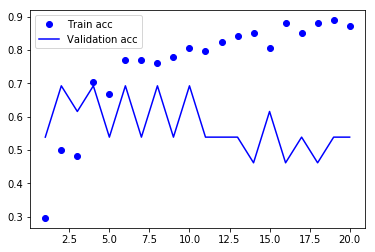

In [39]:
eval_metric(emb_history, 'acc')

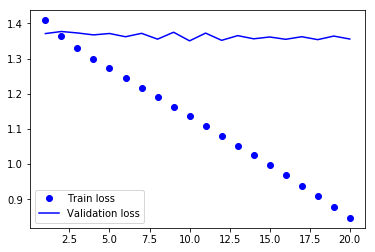

In [40]:
eval_metric(emb_history, 'loss')

In [41]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 20)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

31/31 [==============================] - 0s 31us/step
/n
Test accuracy of word embeddings model: 32.26%


### GloVe Embedding with Softmax

In [42]:
emb_matrix = np.zeros((MAX_NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < MAX_NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [43]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(MAX_NB_WORDS, GLOVE_DIM, input_length=MAX_SEQUENCE_LENGTH))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(5, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1300, 100)         200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 130000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 650005    
Total params: 850,005
Trainable params: 850,005
Non-trainable params: 0
_________________________________________________________________


In [44]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [45]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 108 samples, validate on 13 samples
Epoch 1/20
108/108 [==============================] - 0s 1ms/step - loss: 1.5970 - acc: 0.1204 - val_loss: 6.8961 - val_acc: 0.6923
Epoch 2/20
108/108 [==============================] - 0s 55us/step - loss: 7.4813 - acc: 0.5185 - val_loss: 5.0693 - val_acc: 0.3846
Epoch 3/20
108/108 [==============================] - 0s 65us/step - loss: 7.8321 - acc: 0.3889 - val_loss: 9.8732 - val_acc: 0.0769
Epoch 4/20
108/108 [==============================] - 0s 65us/step - loss: 8.2108 - acc: 0.3704 - val_loss: 7.6414 - val_acc: 0.6923
Epoch 5/20
108/108 [==============================] - 0s 64us/step - loss: 8.3239 - acc: 0.4907 - val_loss: 7.8426 - val_acc: 0.6923
Epoch 6/20
108/108 [==============================] - 0s 65us/step - loss: 8.2357 - acc: 0.5278 - val_loss: 7.8566 - val_acc: 0.3077
Epoch 7/20
108/108 [==============================] - 0s 55us/step - loss: 8.3898 - acc: 0.4259 - val_loss: 6.9166 - val_acc: 0.6923
Epoch 8/20
108/108 [=====

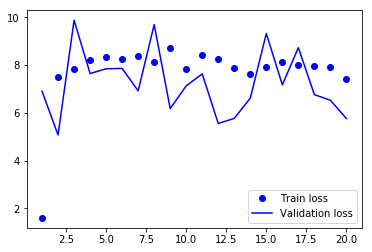

In [46]:
eval_metric(glove_history, 'loss')

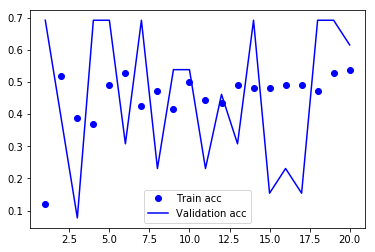

In [47]:
eval_metric(glove_history, 'acc')

In [48]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 20)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

31/31 [==============================] - 0s 64us/step
/n
Test accuracy of word glove model: 22.58%


## Classifiers

In [49]:
type_indicators = [ "Openness", "Conscientiousness", "Exraversion", "Agreeableness", "Neuroticism"]

for l in range(len(type_indicators)):
    print(type_indicators[l])
    print(y_test[:,l])

Openness
[0.4 0.1 0.4 0.2 0.1 0.1 0.4 0.1 0.2 0.1 0.5 0.3 0.1 0.4 0.3 0.5 0.1 0.2
 0.3 0.2 0.1 0.3 0.1 0.2 0.1 0.1 0.3 0.1 0.2 0.2 0.1]
Conscientiousness
[ 0.2  0.1  0.2  0.1  0.1  0.   0.2  0.   0.3  0.1  0.2  0.   0.3  0.
  0.3 -0.2  0.5  0.1  0.3  0.1  0.3  0.   0.1  0.   0.1  0.5  0.4  0.1
  0.2  0.   0. ]
Exraversion
[ 0.4  0.1  0.4  0.1  0.2  0.1  0.1  0.2  0.  -0.1  0.  -0.1  0.2  0.2
  0.2  0.1  0.2  0.1  0.1  0.3  0.2  0.3  0.1  0.1  0.2  0.1  0.3  0.5
 -0.2  0.2  0.1]
Agreeableness
[ 0.1  0.1  0.1  0.   0.2  0.2  0.3  0.2 -0.3  0.1  0.   0.2  0.3  0.
  0.1  0.2 -0.1  0.   0.   0.2  0.1  0.4 -0.1  0.2  0.2 -0.1  0.3  0.1
  0.1 -0.2  0.2]
Neuroticism
[ 0.5  0.1  0.5  0.4  0.4  0.2  0.3 -0.1 -0.2 -0.1 -0.3  0.3  0.1  0.5
  0.2 -0.3 -0.1  0.4  0.2  0.3  0.2  0.1 -0.1 -0.1  0.1  0.1  0.5  0.1
  0.4  0.1  0.2]


In [50]:
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    y_train_class = y_train[:,l]
    y_test_class = y_test[:,l]
    
    print(X_train_seq_trunc.shape, y_train_class.shape)
    seed = 7    
    model = XGBClassifier(learning_rate=0.01,
                             n_estimators=5000,
                             max_depth=4,
                             min_child_weight=6,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=7)

    model.fit(X_train_seq_trunc, y_train_class)
    
    # make predictions for test data
    y_pred = model.predict(X_test_seq_trunc)
    predictions = [value for value in y_pred]
#     # evaluate predictions
#     accuracy = sklearn.metrics.accuracy_score(y_test_class, predictions)
#     f1_score_measure = sklearn.metrics.f1_score(y_test_class, predictions)
    rmse = sklearn.metrics.mean_squared_error(y_test_class, predictions)
    mae = sklearn.metrics.mean_absolute_error(y_test_class, predictions)
    print(" RMSE: {:.3f} MAE: {:.3f}".format(rmse, mae))
    



Openness ...
(121, 1300) (121,)
 RMSE: 0.035 MAE: 0.148


Conscientiousness ...
(121, 1300) (121,)
 RMSE: 0.032 MAE: 0.129


Exraversion ...
(121, 1300) (121,)
 RMSE: 0.039 MAE: 0.158


Agreeableness ...
(121, 1300) (121,)
 RMSE: 0.039 MAE: 0.142


Neuroticism ...
(121, 1300) (121,)
 RMSE: 0.080 MAE: 0.216


In [51]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# Posts in tf-idf representation

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    # Let's train type indicator individually
    y_train_class = y_train[:,l]
    y_test_class = y_test[:,l]

    # split data into train and test sets
    model = svm.LinearSVR(C=10)

    clf = model.fit(X_train_seq_trunc, y_train_class)
    
#     pca = PCA(n_components=2).fit(X_train_seq_trunc)
    
#     pca_2d = pca.transform(X_train_seq_trunc)
    
#     svmClassifier_2d =   svm.LinearSVC(C=10,
#                           class_weight='balanced').fit(   pca_2d, y_train_class)
    
#     for i in range(0, pca_2d.shape[0]):
#         if y_train_res[i] == 0:
#             c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=50,marker='+')
#         elif y_train_res[i] == 1:
#             c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    s=50,marker='o')
    
#     pl.legend([c1, c2], [type_indicators[l][0], type_indicators[l][1]])
#     x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
#     y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),   np.arange(y_min, y_max, .01))
#     Z = svmClassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     pl.contour(xx, yy, Z)
#     pl.title('Support Vector Machine Decision Surface')
#     pl.axis('off')
#     pl.show()
    
    # make predictions  for test data
    y_pred = model.predict(X_test_seq_trunc)
    predictions = [value for value in y_pred]
    # evaluate predictions
#     accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
#     f1_score_measure = sklearn.metrics.f1_score(y_test, predictions)
    rmse = sklearn.metrics.mean_squared_error(y_test_class, predictions)
    mae = sklearn.metrics.mean_absolute_error(y_test_class, predictions)
    print(" RMSE: {:.3f} MAE: {:.3f}".format(rmse, mae))
    



Openness ...
 RMSE: 0.024 MAE: 0.126


Conscientiousness ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 RMSE: 0.026 MAE: 0.129


Exraversion ...
 RMSE: 0.029 MAE: 0.118


Agreeableness ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 RMSE: 0.038 MAE: 0.144


Neuroticism ...
 RMSE: 0.074 MAE: 0.229


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [52]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
encoding = "utf-8"

In [53]:
X, y = np.array(list_posts), np.array(list_personality)
print ("total examples %s" % len(y))

total examples 152


In [54]:
with open(os.path.join(GLOVE_DIR, glove_file), "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [55]:
import struct 

glove_dict = {}
all_words = set(w for words in X)
with open(os.path.join(GLOVE_DIR, glove_file), "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_dict[word] = nums

In [56]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [57]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_dict))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_dict))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [58]:
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [59]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small),
    ("glove_small_tfidf", etree_glove_small_tfidf),
]


type_indicators = ["Openness", "Conscientiousness", "Exraversion", "Agreeableness", "Neuroticism"]

for l in range(len(type_indicators)):
    print(type_indicators[l])
    y = list_personality[:,l]
    unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

Openness


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Unknown label type: (array([ 0.1,  0.2,  0.1,  0.1,  0.4,  0.1,  0.2,  0.1,  0.1,  0.3,  0.2,
        0.5,  0.3,  0.1,  0.2,  0.1,  0.3,  0.1,  0.4,  0.1,  0.1, -0.1,
        0.3,  0.2,  0.1,  0.3,  0.3,  0.2,  0.1,  0.2,  0.2,  0.1,  0.4,
        0.1,  0.4,  0.1,  0.4,  0.1,  0.1,  0.2,  0.3,  0.4,  0.3,  0.2,
        0.2,  0.2,  0.2,  0.2,  0.1,  0.2,  0.3,  0.5,  0.2,  0.1,  0.5,
        0.5,  0.3,  0.3,  0.3,  0.2,  0.4,  0.2,  0.2,  0.1,  0.3,  0.1,
        0.5,  0.1,  0.4,  0.1,  0.2,  0.1,  0.4,  0.3,  0.1,  0.4,  0.2,
        0.2,  0.1,  0.5,  0.1,  0.5,  0.2,  0.2,  0.3,  0.2,  0.4,  0.2,
        0.3,  0.1,  0.1,  0.1,  0.4,  0.5,  0.1,  0.3,  0.1,  0.5,  0.4,
        0.3,  0.1,  0.1,  0.1,  0.2,  0.1,  0.5,  0.2,  0.1,  0.4,  0.1,
        0.3,  0.2,  0.1,  0.1,  0.4,  0.5,  0.2,  0.2,  0. ,  0.3,  0.1]),)